Found 396 images belonging to 3 classes.
Found 97 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 508s 10s/step - accuracy: 0.4181 - loss: 1.0203 - precision: 0.5416 - recall: 0.2383 - val_accuracy: 0.2577 - val_loss: 1.3019 - val_precision: 0.2022 - val_recall: 0.1856 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 486s 10s/step - accuracy: 0.6592 - loss: 0.8207 - precision: 0.7511 - recall: 0.4648 - val_accuracy: 0.2577 - val_loss: 1.3062 - val_precision: 0.2577 - val_recall: 0.2577 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 476s 10s/step - accuracy: 0.7104 - loss: 0.7118 - precision: 0.7643 - recall: 0.6045 - val_accuracy: 0.2577 - val_loss: 1.5434 - val_precision: 0.2577 - val_recall: 0.2577 - learning_rate: 1.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 490s 10s/step - accuracy: 0.6902 - loss: 0.7645 - precision: 0.7610 - recall: 0.5802 - val_accuracy: 0.2577 - val_loss: 1.9084 - val_precision: 0.2577 - val_recall: 0.2577 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 490s 10s/s

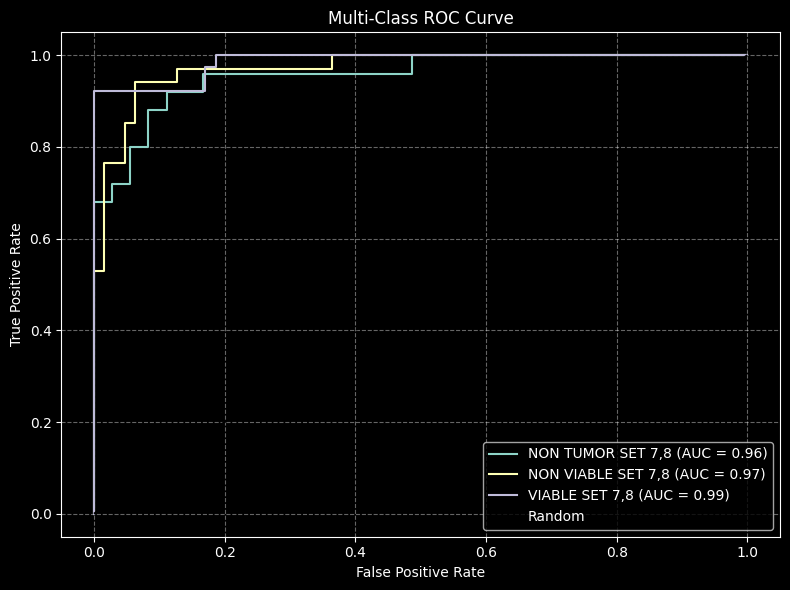

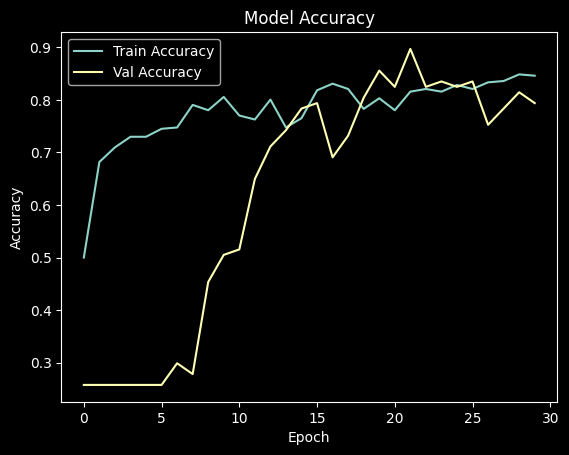

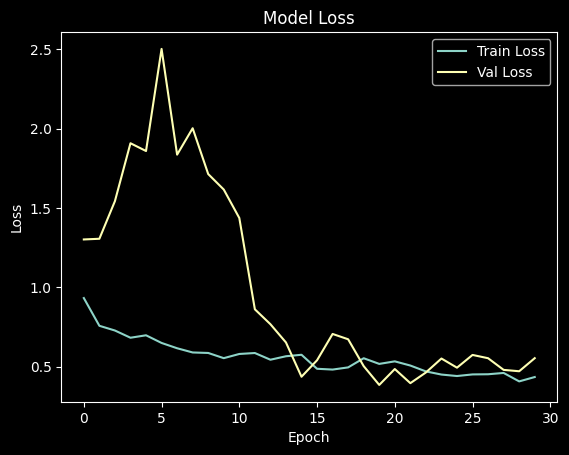

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
68.67% confidence this is NON VIABLE SET 7,8
Predicted Severity: Moderate
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


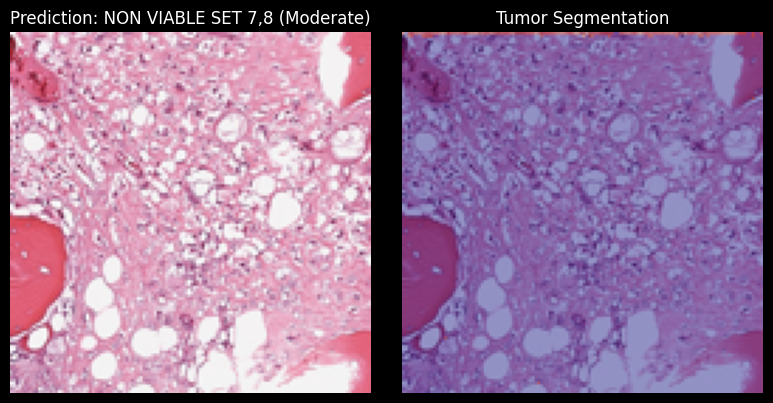

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('dark_background')

# Paths and config
data_dir = "/content/drive/MyDrive/cancer data"
img_size = (128, 128)
batch_size = 8

# Data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_data.class_indices.keys())

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# MobileViT-like block
def mobilevit_block(x, filters, transformer_dim, num_heads, name):
    x_local = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x_local = layers.BatchNormalization()(x_local)
    b, h, w, c = x_local.shape
    x_patch = layers.Reshape((h * w, c))(x_local)

    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=transformer_dim)(x_patch, x_patch)
    attn_output = layers.LayerNormalization()(attn_output)
    ffn = layers.Dense(c, activation='relu')(attn_output)
    x_patch = layers.Add()([x_patch, ffn])

    x_reshaped = layers.Reshape((h, w, c))(x_patch)
    x_reshaped = layers.Conv2D(filters, 1, padding='same', activation='relu')(x_reshaped)
    x_reshaped = layers.BatchNormalization()(x_reshaped)
    return x_reshaped

# MobileViT Classification Model
def build_model():
    inputs = Input(shape=(128, 128, 3))
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = mobilevit_block(x, filters=32, transformer_dim=64, num_heads=2, name="mobilevit_1")
    x = layers.MaxPooling2D()(x)

    x = mobilevit_block(x, filters=64, transformer_dim=96, num_heads=2, name="mobilevit_2")
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    return models.Model(inputs, outputs)

# U-Net Segmentation Model
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

# Compile and load models
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

seg_model = unet_model()
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=30, min_lr=1e-6)

# Train
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Classification Report
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# ROC and AUC Plot
y_true_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])
y_score = y_pred

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Accuracy and Loss Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Prediction with Segmentation
def predict_image(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    # Classification
    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    # Segmentation
    mask = seg_model.predict(arr)[0, :, :, 0]
    mask = (mask > 0.5).astype(np.uint8)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img)
    ax[0].set_title(f"Prediction: {class_names[class_idx]} ({severity})")
    ax[0].axis('off')

    ax[1].imshow(img)
    ax[1].imshow(mask, alpha=0.4, cmap='jet')
    ax[1].set_title("Tumor Segmentation")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# Run prediction
predict_image("/content/Case-48-P5-C23-28780-10637.jpg")